---
title: "Object Detection from ResNET34 Model"
date: "2018-06-06"
path: "/object-detection-from-resnet34-model/"
category: "Projects"
thumbnail: "thumbnail.jpg"
---

Object Detection is still one of the big open problems in the Computer Vision world. Convolutional Neural Networks have made incredible strides towards solving this problem, which have led to robust A.I systems dealing with face detection, people counting, object tracking and image content filtering. 

In the write-up below I walk through steps taken to develop an algorithm that will make a prediction on what is in the image and where it is. The code leverages the fastai library; a framework for quickly processing data and training transfer-learning models, written on top of PyTorch. Kudos to Jeremy Howard for his excellent courses on deep learning and the library he has created.

The goal of this project is to walk through data preparation techniques and algorithm development in order to build a model that can identify and locate objects in an image. 

#### Libraries used

In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [2]:
# Pretty Printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## The Dataset
---
I downloaded and unzipped the PASCAL image dataset, which contains I believe roughly 50k images, along with meta data describing each image. The PASCAL dataset is one of the most popular datasets for training an object detection or image segmentation model. 

The meta-data is packaged in a json file, so I'm going to load in the file and take a look at the internal structure. Ultimately I want to extract the labels and paths to the image files from this json file so I can have a prepared dataset to feed into my model.

In [3]:
# my cloud Computer has slightly different path than local
if os.path.isdir('data/pascal/VOCdevkit'):
    PATH = Path('data/pascal/VOCdevkit')
else:
    PATH = Path('data/pascal')
    print(PATH)
with open(PATH/'../pascal_train2007.json', 'r') as f:
    data = json.load(f)

In [7]:
printmd('**pascal_train json file:**')
for k in data.keys():
    print('+--',k, type(data[k]))
    if type(data[k]) == list:
        for m, i in data[k][0].items():
            print('   +--',m, type(i))
    else:
        print('    +--', data[k], type(data[k]))

**pascal_train json file:**

+-- images <class 'list'>
   +-- file_name <class 'str'>
   +-- height <class 'int'>
   +-- width <class 'int'>
   +-- id <class 'int'>
+-- type <class 'str'>
    +-- instances <class 'str'>
+-- annotations <class 'list'>
   +-- segmentation <class 'list'>
   +-- area <class 'int'>
   +-- iscrowd <class 'int'>
   +-- image_id <class 'int'>
   +-- bbox <class 'list'>
   +-- category_id <class 'int'>
   +-- id <class 'int'>
   +-- ignore <class 'int'>
+-- categories <class 'list'>
   +-- supercategory <class 'str'>
   +-- id <class 'int'>
   +-- name <class 'str'>


## Preparing and Preprocessing Data
The following steps detail preprocessing steps taken to restructure the data so it's more accessible during development. 


#### Create File and Category Dictionary from image IDs

In [5]:
category = {cat_dic['id']: cat_dic['name'] for cat_dic in data['categories']}
filename = {img_dic['id']: img_dic['file_name'] for img_dic in data['images']}
imageIDs = [img['id'] for img in data['images']]

## Get Image Paths

In [6]:
import os

img_path = PATH/'VOC2007/JPEGImages'
    
print('file paths of a few images:')
list(img_path.iterdir())[:3]

file paths of a few images:


[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006948.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005796.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007006.jpg')]

## Create label dataset for images
The labels we want to predict (namely; the image label and the location of the object in the image) are tucked away a bit. The Machine Learning framework I am using to train the model likes to have the data tabulated. Since I want to leverage the prebuilt training functions, I will do a bit of pre-processing of the data to get it in a machine learning friendly format. 

One aspect of this may be more of a personal taste, but one thing to consider is having the bounding box labels as *xy*, height, width  or *x1, y1, x2, y2* coordinates. Data science calculations and the numpy library prefer one format, while image plotting prefers another. The following details some conversion functions that will allow me to use both interchangeably. 

### Conversion Functions

In [7]:
def convert_bbox(bbox): 
    """
    convert bounding box from x, y, height width,
    to x1, y1 (top left) & x2, y2 (bottom right)
    """
    return np.array([bbox[1], 
                     bbox[0], 
                     bbox[3] + bbox[1] - 1, 
                     bbox[2] + bbox[0] - 1]) 

def revert_bbox(bbox):
    """
    revert bounding box back to original dimensions
    """
    return np.array([bbox[1], 
                 bbox[0], 
                 bbox[3] - bbox[1] + 1, 
                 bbox[2] - bbox[0] + 1])

### Display Conversion

In [8]:
annotation = data['annotations'][0]  
annotation # annotation information of first data point

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [12]:
bbox = annotation['bbox']
print('current box configuration:\n\t'
          'x (left):  {}\n\t'
          'y (lower): {}\n\t'
          'Width:     {}\n\t'
          'Height:    {}\n\t'.format(*bbox))
print('converted box configuration:\n\t'
          'y (lower): {}\n\t'
          'x (left):  {}\n\t'
          'y (top):   {}\n\t'
          'x (right): {}\n\t'.format(*convert_bbox(bbox)))

current box configuration:
	x (left):  155
	y (lower): 96
	Width:     196
	Height:    174
	
converted box configuration:
	y (lower): 96
	x (left):  155
	y (top):   269
	x (right): 350
	


### Create Ground Truth Dictionary from Annotations
Time to extract the labels and the bounding boxes into a dictionary.

In [9]:
labels = collections.defaultdict(lambda: [])
i = 0 
for img_ann in data['annotations']:
    if not img_ann['ignore']:
        imgID = img_ann['image_id']
        catID = img_ann['category_id']
        bbox = img_ann['bbox']
        bbox = convert_bbox(bbox)
        labels[imgID] += [(bbox, catID)]

In [11]:
printmd('**Testing Label Dictionary on Image ID 17:**')
(lambda l: [print('bbox:',x, 'label:', category[y]) for x, y in l])(labels[17]);

**Testing Label Dictionary on Image ID 17:**

bbox: [ 61 184 198 278] label: person
bbox: [ 77  89 335 402] label: horse


### Single Object Detection: Working with only the Largest Labeled Object 

For starters we're going to do recognition and detection on the largest object in the image. The dataset has multiple annotations per image (as seen above with Image 17), which may affect the ability of our model to predict the single largest image, but we can address that later.

In [81]:
# Create CSV of filenames and category label of largest object in image
def get_largest_object(imgID):
    """
    returns single image label of largest object in image.
    """
    global labels
    return sorted(labels[imgID], key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)[0]

largest_object = {ID: get_largest_object(ID) for ID in imageIDs}

### Create Image Visualization Functions: Bounding Box, Labels and Images

In [10]:
def add_outline(obj, w):
    """
    Receives in an axis object and line width for the box, creates a patch.
    """
    obj.set_path_effects([patheffects.Stroke(linewidth=w, foreground='black'),
                          patheffects.Normal()])
    
def annotate_img(ax, bbox=None, label=None):
    ID, bbox = label, bbox
    
    if bbox is not None:
        bbox = revert_bbox(bbox)
        patch = patches.Rectangle(bbox[:2], *bbox[-2:], 
                                  fill=False, edgecolor='white', lw=2)

        box = ax.add_patch(patch)
        add_outline(box, 4)
    else:
        bbox = [.5, 0.9]
        
    if ID:
        txt = ax.text(*bbox[:2],s=category[ID],  
                      verticalalignment='top',
                      color='white',
                      fontsize=14,
                      weight='bold')

        add_outline(txt, 1)

        
def display_img(img, bbox=None, label=None, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
    annotate_img(ax, bbox, label)
    
    return ax

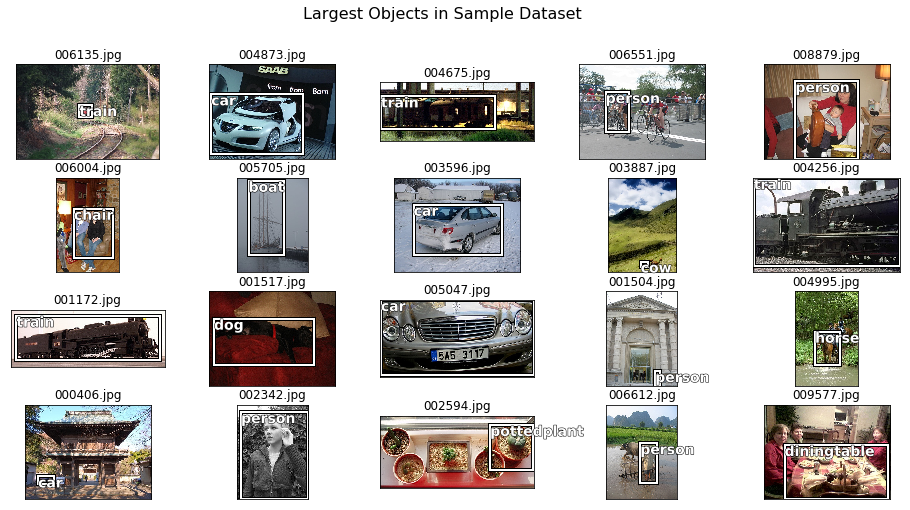

In [14]:
fig, axs = plt.subplots(4, 5, figsize=(16,8))
fig.suptitle('Largest Objects in Sample Dataset', size=16)
axs = axs.flatten()
for ax in axs:
    # Pick a random image
    imID = np.random.choice(imageIDs)
    
    file = filename[imID]
    ax.set_title(str(file))
    
    im = open_image(img_path/file)
    
    label_data = largest_object[imID]
    display_img(im, *label_data, ax=ax)

## Store Data Labels to a CSV
I am going to take the label dictionary I created earlier and store the information in a simple CSV.

In [5]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/largest-labels.csv'
CSV_BB = PATH/'tmp/largest-bbox.csv'

In [16]:
# Create CSV of data
import pandas as pd

d1 = pd.DataFrame(
    {
    'file':     [filename[ID] for ID in imageIDs], 
    'category': [largest_object[ID][1] for ID in imageIDs]
    }, 
    columns=['file', 'category'])

d2 = pd.DataFrame(
    {
    'file': [filename[ID] for ID in imageIDs], 
    'bbox': [' '.join([str(i) for i in largest_object[ID][0]]) for ID in imageIDs]
    }, 
    columns=['file', 'bbox'])

d1.to_csv(CSV, index=False)
d2.to_csv(CSV_BB, index=False)

printmd('**Top rows from training label CSV file**')
d2.merge(d1, on=['file']).head()


**Top rows from training label CSV file**

,file,bbox,category
0,000012.jpg,96 155 269 350,7
1,000017.jpg,77 89 335 402,13
2,000023.jpg,1 2 461 242,15
3,000026.jpg,124 89 211 336,7
4,000032.jpg,77 103 182 374,1


In [17]:
del d1
del d2

## Prepare Data with Augmentation

Deep Learning models are very prone to overfitting. The numerous layers lead to an enormous amount of parameters that tune themselves to map inputs to outputs, and the high dimensionality of these deep models can easily lead to poor generalization on unseen data. The best way to fight overfitting is to get more data: a larger distribution of samples that represent the chosen ground truth labels. If you don't have access to more samples, the second best way is to aritifically make some. Maybe a cat is a cat whether it's red or grey or white? If you just have a white picture of a cat, maybe make a couple samples of different colors. If a cat is looking left, it's still a cat if it looks right, so maybe flip the image. 

To increase the robustness of the model we're traingin here, we will inforporate a lot of augmentation tactics to each image. sample images are rotated slightly, flipped and get some lighting adjusments. 

One implementation detail: When an image is translated or rotated, the bounding box labels need to also be adjusted in the same way so the bounding box ground truth still overlaps the objects. 

We'll start by augmenting the image data and transforming the bounding boxes to match, then we'll grab the label data and join it with the transformed bounding box data to get a single dataset of samples and labels.

In [6]:
size = 224
batch_size = 64
JPEGS = 'VOC2007/JPEGImages'

# y labels are coordinates, make sure transorm adjusts dependent variable (y) as well
augmenter = [RandomFlip(tfm_y=TfmType.COORD), 
             RandomRotate(30, tfm_y=TfmType.COORD), 
             RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)]

transform = tfms_from_model(resnet34, size, aug_tfms=augmenter, tfm_y=TfmType.COORD, crop_type=CropType.NO)

bbox_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV_BB, tfms=transform, bs=4, continuous=True)
lbls_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(resnet34, size), bs=batch_size)

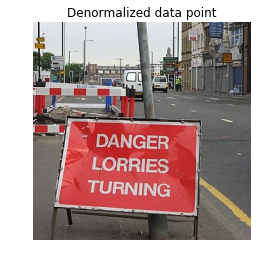

In [19]:
x, y = next(iter(lbls_data.trn_dl))
img  = lbls_data.val_ds.denorm(to_np(x))[0]

fig, ax = plt.subplots()
ax.imshow(img)
_ = plt.axis('off')
_ = plt.title('Denormalized data point')

In [16]:
torch.cuda.device(0)

## Creating a CNN Model for Image Recognition
---
The first part of this Object Detection journey is to build a model to at least recognize objects in the image. This is a classification task, so we're going to take a pre-trained base model from the ResNet34 architecture, inherit the optimized weights and learn a new objective with the dataset we're working with.

In [35]:
base_model = resnet34

In [36]:
# Create a trainer
trainer = ConvLearner.pretrained(base_model, lbls_data, metrics=[accuracy])
trainer.opt_fn = optim.Adam

In [37]:
trainer.lr_find(1e-5, 100)

 78%|███████▊  | 25/32 [00:04<00:01,  5.50it/s, loss=11.9]


#### Training Loss Recorded at each Increase of Learning Rate

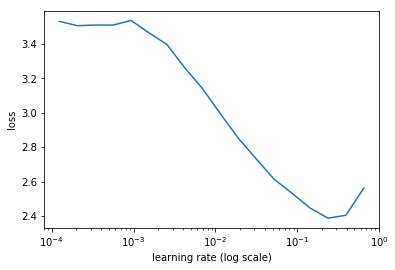

In [38]:
printmd("#### Training Loss Recorded at each Increase of Learning Rate")
trainer.sched.plot(n_skip=5, n_skip_end=1)

### Observations
What this graph indicates is a callback routine that increases the learning rate at each batched iteration of training. At the start of training, the learning rate is too low to see any considerable decrease in predictive error of the model. As the learning rate increases, the loss begins to decrease at a faster rate (hence the change in slope). There comes a point in the learning rate setting where the loss no longer decreases, and instead begins to increase, which means the learning rate is too high and the large gradient update is causing the weights of the model to bounce around instead of descending towards a minima. We want to select a learning rate before this happens; ideally where the slope of loss is the steepest. 

### Setting the Learning Rate

In [39]:
lr = 2e-2

## Evaluate Pre-trained model

In [40]:
trainer.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.225846   0.659903   0.804     



[array([ 0.6599]), 0.80400000286102291]

## Observations
Out of the box, the model performs very well on Object detection. To put an accuracy of 81.2% in perspective; a random guess would be correct 10% of the time if there were 10 classes to guess on. Needless to say, random guessing is economically useful for probably most tasks, so better than random may still be useless depending on the task. Let's keep optimizing the model.

### Setup a Learning Rate Scheduler
Different sections of a deep learning model have weights of different magnitude that are more sensitive to gradients. Generally it's good practice to tweak the weights closer to the input image less than top layer weights. What is a reasonable step to make for one layer may be way too big for the other.

**A good inituition on learning rates is that the gradient step (Learning rate * raw gradient) should be 0.1% of the actual weights.**

The library allows for setting different learning rates that can apply to different areas of the model, so we'll set the learning rate for initial layers a few orders of magnitiude smaller than the later layers.

In [30]:
lr_sched = np.array([lr/1000, lr/100, lr])

In [31]:
trainer.freeze_to(-2)
trainer.fit(lr_sched, n_cycle=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.20484    1.030448   0.752     



[array([ 1.03045]), 0.75199999952316288]

## Observations
The model actually decreased in accuracy after training the top layers! This might mean the learning rate was set too high.

### Freeze up to last two layers, train the last two layers

## Determine appropriate learning rate

 81%|████████▏ | 26/32 [00:07<00:01,  3.70it/s, loss=2.25]


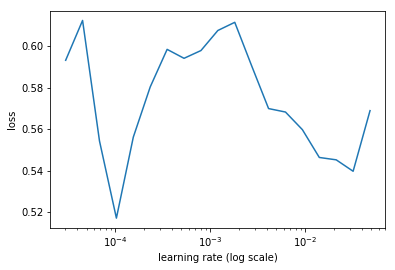

In [32]:
printmd('## Determine appropriate learning rate')
lr_finder = trainer.lr_find(lr_sched/1000)
trainer.sched.plot(1)

## Observations
Perhaps the learning rate should be be reduced slightly. 1e-2 seems too high

### Train for another epoch

In [33]:
trainer.fit(lr_sched/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.466305   0.730799   0.81      



[array([ 0.7308]), 0.81000000238418579]

### Unfreeze all layers, continue training

In [34]:
trainer.unfreeze()
trainer.fit(lr_sched/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.344427   0.665965   0.808     
    1      0.244174   0.643385   0.806     



[array([ 0.64338]), 0.8059999976158142]

## Obversations
The model accuracy did not change from one epoch to the next, and it looks like the training loss went down even though validation loss stayed roughly the same -- this indicates that there is a good chance further training will lead to overfitting; the model will learn intricacies of the training data more closely without improving it's ability to generalize to unseen data. 

It's possible that since the model is trained to classify a single label, while the images contain multiple objects, there could be a mislabeling based on the object the model chooses to focus on. For example, say there's an image with both a dog and a cat. If the dog is the largest object and what we want to classify, but the model labels the image as a cat (due to it's single object detection nature), it will misclassify.

I'm going to say 80% classification is satisfactory for now and move on to running predictions.

### Run a prediction
The model is trained with somewhat reasonable accuracy. The challenge here is trying to predict what the largest item is in the sample dataset when the sample dataset includes smaller objects in the same image. We're going to take the model with the accuracy as is and run some predictions.

In [75]:
x, y = next(iter(lbls_data.val_dl))
prob = F.softmax(predict_batch(trainer.model, x), -1)
x, preds = to_np(x), to_np(prob)
preds = np.argmax(preds, -1)

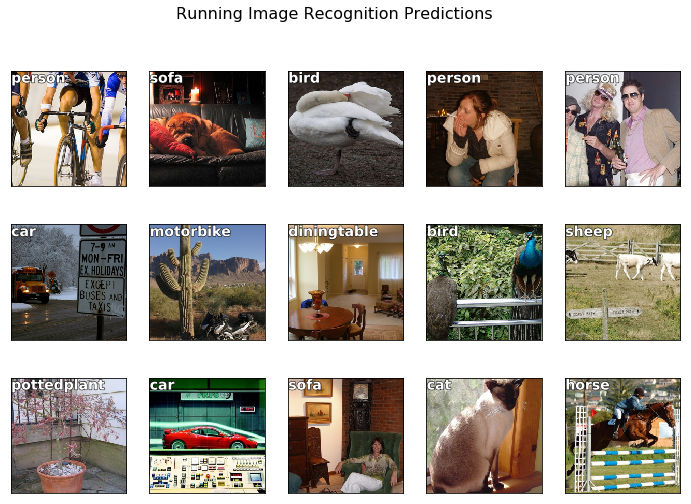

In [76]:
fig, axes = plt.subplots(3,5, figsize=(12,8))
fig.suptitle('Running Image Recognition Predictions', size=16)
for i, ax in enumerate(axes.flat):
    image = lbls_data.val_ds.denorm(x)[i]
    label = int(lbls_data.classes[preds[i]])
    display_img(image, label=label, ax=ax)
    

In [129]:
printmd('**First five rows of bounding box label CSV file**')
with open(CSV_BB, 'r') as f:
    for l in f.readlines()[:5]:
        print(l.replace(',', ('\t\t' if l[0] =='f' else '\t')))

**First five rows of bounding box label CSV file**

file		bbox

000012.jpg	96 155 269 350

000017.jpg	77 89 335 402

000023.jpg	1 2 461 242

000026.jpg	124 89 211 336



## Creating a CNN Model for Object Detection
---

### Visualize Augmented Data with Bounding Box

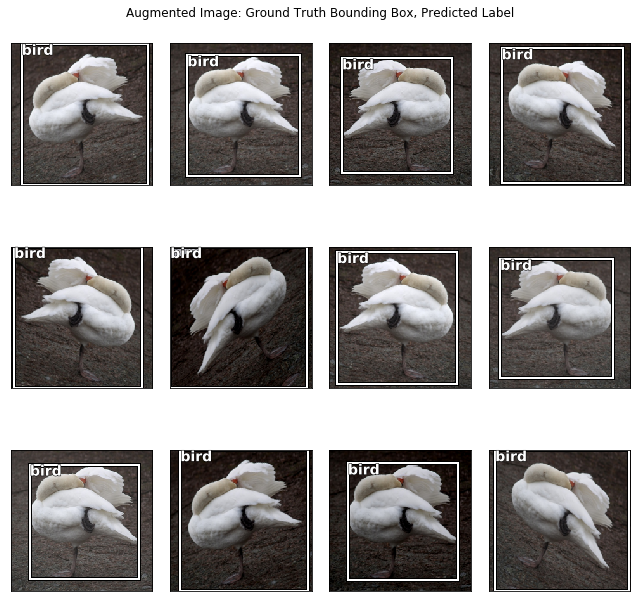

In [29]:
#Pick an image index to render (batch of 4 images)
idx = 2
fig, ax = plt.subplots(3, 4, figsize=(9,9))
preds = None
for i, axs in enumerate(ax.flat):
    
    x, y = next(iter(bbox_data.aug_dl))
    # Get image and box from augmented data
    img = bbox_data.val_ds.denorm(to_np(x))[idx]
    box = to_np(y[idx])
    
    # Predict the label
    if preds is None:
        preds = F.softmax(predict_batch(trainer.model, x), -1)
        preds = to_np(preds)
        preds = np.argmax(preds, -1)
        preds = int(lbls_data.classes[preds[idx]])
        
    display_img(img, label=preds, bbox=box, ax=axs)
    
fig.suptitle('Augmented Image: Ground Truth Bounding Box, Predicted Label')
fig.tight_layout()

## Combing Labels and Bounding Boxes With Images into One Dataset

In [14]:
RESNET = resnet34
sz = 224
bs = 64
val_idxs = get_cv_idxs(len(filename))

# my cloud Computer has slightly different path than local
if os.path.isdir('data/pascal/VOCdevkit'):
    PATH = Path('data/pascal/VOCdevkit')
else:
    PATH = Path('data/pascal')
    print(PATH)
with open(PATH/'../pascal_train2007.json', 'r') as f:
    data = json.load(f)
    
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/largest-labels.csv'
CSV_BB = PATH/'tmp/largest-bbox.csv'
JPEGS = 'VOC2007/JPEGImages'

class ConcatLblDataset(Dataset):
    
    def __init__(self, ds, y2): 
        self.ds = ds
        self.y2 = y2
        
    def __len__(self): 
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))
    
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

# Create Transform and image classifier data from CSV
transform = tfms_from_model(RESNET, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
bbox_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV_BB, tfms=transform, bs=bs, continuous=True, val_idxs=val_idxs)
name_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(RESNET, sz))

# Concatenate the labels to the bounding box dataset
concat_train = ConcatLblDataset(bbox_data.trn_ds, name_data.trn_y)
concat_valid = ConcatLblDataset(bbox_data.val_ds, name_data.val_y)

# Replace the dataset with these concatenated datasets
image_data = bbox_data
image_data.trn_dl.dataset = concat_train
image_data.val_dl.dataset = concat_valid

del bbox_data
del concat_train
del concat_valid

## Creating Detection Model

In [15]:
# Custom un-trained top layers
regression_head = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4 + len(category))
)

# Build a Convolutional Neural Network from pretrained ResNET
base_model = ConvnetBuilder(RESNET, 0, 0, 0, custom_head=regression_head)
trainer = ConvLearner(image_data, base_model)

trainer.opt_fn = optim.Adam

## Observations
The last layer of the model is a *bounding box + categories* vector output, which provides the predicted values for the 4 points of the bounding box plus the probabilities of each class. In order to calculate the loss, we need to split the prediction vector into two arrays and apply a different loss function for each segment. The Bounding Box regression model would use an l1 loss while the category classification would use a cross entropy loss.

### Custom Loss Functions

In [16]:
def c_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def c_L1(input, target):
    bb_t, _ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data
    
def c_accuracy(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)


## Begin Training, Search for Learning Rate

In [17]:
trainer.crit = c_loss
trainer.metrics = [c_accuracy, c_L1]

In [18]:
trainer.lr_find()

 94%|█████████▍| 30/32 [00:07<00:00,  4.20it/s, loss=517]


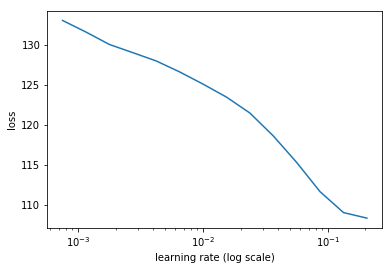

In [19]:
trainer.sched.plot()

In [20]:
lr = 1e-3
trainer.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   c_accuracy c_L1       
    0      110.116441 78.790763  0.782      60.250147 
    1      94.266435  69.14885   0.828      52.567067 
    2      82.389443  60.218006  0.822      44.285609 



[array([ 60.21801]), 0.82199999809265134, 44.285608886718748]

In [21]:
trainer.freeze_to(-2)
lrs = np.array([lr/100, lr/10, lr])
trainer.fit(lr/1000, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   c_accuracy c_L1       
    0      71.683878  62.39245   0.822      46.004802 
    1      72.08925   62.811565  0.824      46.603734 
    2      71.430985  62.464286  0.824      46.191416 



[array([ 62.46429]), 0.8240000023841858, 46.191415832519532]

After training for a few epochs, I'm going to reduce the learning rate by a few orders of magnitude and continue training the weights across the network. I want to reduce the gradient updates on earlier parts of the network where there was already pre-training, but keep the learning rate on the later gradients higher.

In [23]:
trainer.sched.plot()

AttributeError: 'CosAnneal' object has no attribute 'plot'

## Observations:
Loss starts to increase when the learning rate is higher than 10e-3. We'll keep the learning rate as it's set, unfreeze one more layer in the pretrained model and continue training.

In [24]:
trainer.freeze_to(-3)
trainer.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss   c_accuracy c_L1       
    0      65.01083   47.136854  0.826      33.88456  
    1      54.240846  42.824002  0.828      29.762054 



[array([ 42.824]), 0.82800000286102293, 29.762053649902345]

## Continue Training On All Layers
The top layers have been trained a bit from random intialization to close to (hopefully) the optimal parameters. I'm going to unfreeze the whole network and train all the layers for several epochs.

In [25]:
trainer.unfreeze()
trainer.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   c_accuracy c_L1       
    0      46.644491  41.282319  0.838      28.554704 
    1      45.133588  38.875178  0.83       26.615679 
    2      43.658426  38.005706  0.85       26.121076 
    3      41.97118   37.091973  0.832      25.305689 
    4      40.160971  36.848199  0.846      25.064068 
    5      38.446587  36.161445  0.846      24.629682 
    6      37.604964  35.888004  0.846      24.448113 
    7      36.57852   35.617709  0.842      24.24911  
    8      35.998207  35.325163  0.842      23.915489 
    9      35.321802  35.349842  0.844      23.965771 



[array([ 35.34984]), 0.84399999809265136, 23.965771392822266]

In [26]:
trainer.save('Final_Model')

### Run predictions on sample set

In [28]:
y = trainer.predict()
x, _ = next(iter(image_data.val_dl))

### Running Prediction on Sample Images...

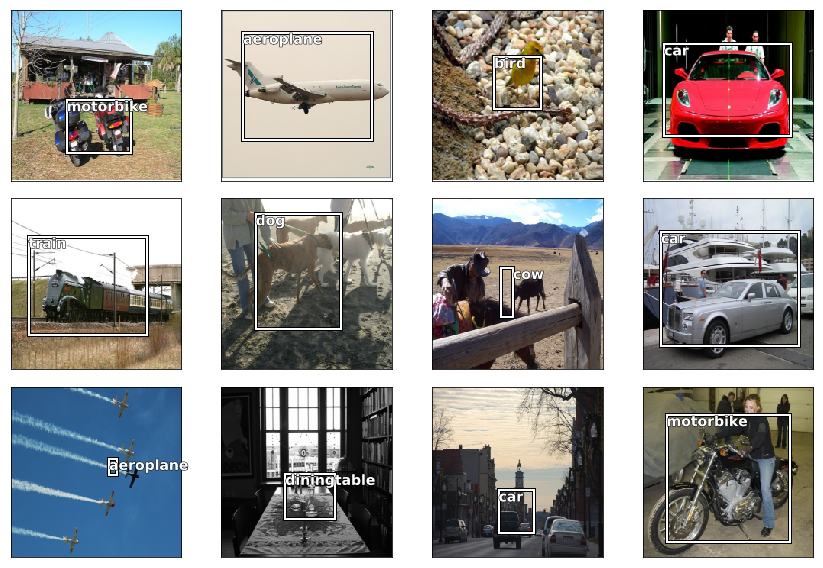

In [34]:
from scipy.special import expit

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    i = i + 30  # look at different image set
    # Get a de-normalized image
    ima = image_data.val_ds.ds.denorm(to_np(x))[i]
    
    # Get bounding Box from prediction vector
    bb = expit(y[i][:4]) * 224  # multiplied by image size
    
    # Get Class Label from prediction vectpr
    c = np.argmax(y[i][4:])
    c = int(name_data.classes[c])
    
    # Plot
    ax = display_img(ima, bb, c, ax=ax)
    
printmd('### Running Prediction on Sample Images...')
plt.tight_layout()